In [1]:
#importing libraries

import torch, pdb # Torch is the p=PyTorch library and pdb is a pythondebugger library
from torch.utils.data import DataLoader # Predefined function to load our Data
from torch import nn # Some deeplearning frameworks
from torchvision import transforms # Helps to transform our dataset
from torchvision.datasets import MNIST # Data set
from torchvision.utils import make_grid # for comparing the fake and real datas
from tqdm.auto import tqdm # for creating a progress bar
import matplotlib.pyplot as plt # UK

In [2]:
# function to use make_grid function to visualise data
'''
Here, show function helps us to visualise the data by using matplotlib and
make_grid function.
The inputs fo rthis function are
-> tensor = an n dimensional array.
MNIST data set has images of size 28*28, and our batchsize for  this particular
program is going to be 128, so each tensor is of the size

 == 128*784(28*28)

-> ch means channels. MNIST dataset only contain black and white images
so number of channels will be 1.

-> size means the size of the image in the dataset so that we can visualise

-> num is used for the number of images that can be used in one grid.
'''
def show(tensor, ch=1, size=(28,28), num=16):
  data = tensor.detach().cpu().view(-1,ch,*size)
  grid = make_grid(data[:num], nrow=4).permute(1,2,0)
  plt.imshow(grid)
  plt.show()

'''
Here .detach() function it creates a new tensor that acts as a copy of a part
of the computation graph, and any operations performed on the detached tensor will
not be tracked for automatic differentiation. This makes the detached tensor a leaf in the computation graph.
So the final outcome data will be of 128*1*28*28
The new image creation is done by gpu but visualisation is doen in cpu
Then mdata[:num] is used to select the number of images we want in a grid, i.e., 16
nrows is the number of rown since 4*4 will be sixteen so 4.
premute is used to fit the grid to be used by matplot lib since tensor will be in fromat 1*28*28[ch*len*width]
, but for matplotlib we need that to be in the format 28*28*1 [len*width*ch]
'''


'\nHere .detach() function it creates a new tensor that acts as a copy of a part\nof the computation graph, and any operations performed on the detached tensor will\nnot be tracked for automatic differentiation. This makes the detached tensor a leaf in the computation graph.\nSo the final outcome data will be of 128*1*28*28\nThe new image creation is done by gpu but visualisation is doen in cpu\nThen mdata[:num] is used to select the number of images we want in a grid, i.e., 16\nnrows is the number of rown since 4*4 will be sixteen so 4.\npremute is used to fit the grid to be used by matplot lib since tensor will be in fromat 1*28*28[ch*len*width]\n, but for matplotlib we need that to be in the format 28*28*1 [len*width*ch]\n'

In [13]:
# Parameters and hyperparameters
num_epochs = 500
curr = 0
info_epoch = 250 # The num of epoch after which u want to see the looss
mean_disc_loss = 0
mean_gen_loss = 0

nois_dim = 64  # the dimension/size of the noise which can be used for generator
learning_rate = 0.00001 # Adam Optimiser
loss_fncn = nn.BCEWithLogitsLoss() # This will calcuolate the loss by applying sigmoid function os the outputs so that they will be normalised.

batch_size = 128
device = 'cuda' # the training takes place in either CPU or GPU(cuda)

# It will transform the data from MNIST to Tensors which we are going to use and shuffle the data for each batch
dataloader = DataLoader(MNIST('.', download = True, transform = transforms.ToTensor()), shuffle = True, batch_size=batch_size)

'''
There is no specific size for the dimension to be used for the noise, the only suggestion is dont take the dimension to be
to huge, if your noise size is huge, u need to have a complex generator for having good results
'''

'\nThere is no specific size for the dimension to be used for the noise, the only suggestion is dont take the dimension to be\nto huge, if your noise size is huge, u need to have a complex generator for having good results\n'

In [4]:
'''
-> We are creating Generator and discriminator using blocks
-> nn.Module is a fundamental class that serves as the base class for all neural network modules. It is an essential component of building neural network models using PyTorch.
-> When you define your own custom neural network architectures, you typically create subclasses of nn.Module to build the layers and define the forward pass.
->
'''


'\n-> We are creating Generator and discriminator using blocks\n-> nn.Module is a fundamental class that serves as the base class for all neural network modules. It is an essential component of building neural network models using PyTorch.\n-> When you define your own custom neural network architectures, you typically create subclasses of nn.Module to build the layers and define the forward pass.\n->\n'

In [5]:
from torch.nn.modules.activation import Sigmoid
# Generator function

def gen_block(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.BatchNorm1d(out),
      nn.LeakyReLU(0.2)
  )

class Generator(nn.Module):
  def __init__(self, nois_dim=64, out_dim=784, hidden_dim=128):
    super().__init__()
    self.gen=nn.Sequential(
        gen_block(nois_dim, hidden_dim),
        gen_block(hidden_dim, hidden_dim*2),
        gen_block(hidden_dim*2, hidden_dim*4),
        gen_block(hidden_dim*4, hidden_dim*8),
        gen_block(hidden_dim*8, hidden_dim*10),
        nn.Linear(hidden_dim*10, out_dim),
        nn.Sigmoid()
    )

  def forward(self, noise):
    return self.gen(noise)


def create_noise(num, nois_dim):
  return torch.randn(num, nois_dim).to(device)

In [6]:
from torch.nn.modules.linear import Linear
from IPython.core.interactiveshell import dis
# Discriminator Function

def disc_block(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.ReLU(inplace=True)
  )

class Discriminator(nn.Module):
  def __init__(self, in_dim=784, hidden_dim=256):
    super().__init__()
    self.disc=nn.Sequential(
        disc_block(in_dim, hidden_dim*6),
        disc_block(hidden_dim*6, hidden_dim*4),
        disc_block(hidden_dim*4, hidden_dim*2),
        disc_block(hidden_dim*2, hidden_dim),
        nn.Linear(hidden_dim, 1)
    )

  def forward(self, image):
    return self.disc(image)


In [7]:
gen = Generator(nois_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=learning_rate)
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Linear(in_features=1024, out_features=1

In [8]:
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=learning_rate)
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1536, bias=True)
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=1536, out_features=1024, bias=True)
      (1): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU(inplace=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

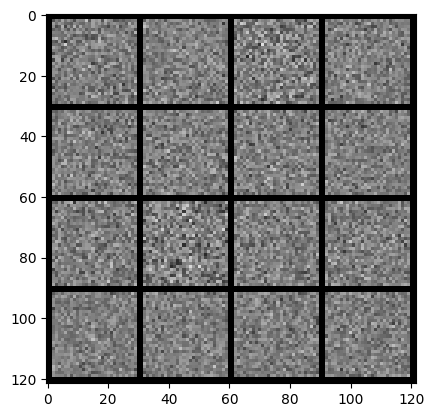

In [9]:
noise = create_noise(batch_size, nois_dim)
fake = gen(noise)
show(fake)

In [10]:
# Calculating loss for both generator and discriminator

def calc_gen_loss(loss_fncn, gen, disc, num, nois_dim):
  noise = create_noise(num, nois_dim)
  fake = gen(noise)
  pred = disc(fake)
  fake_target = torch.ones_like(pred)
  gen_loss = loss_fncn(pred, fake_target)

  return gen_loss


def calc_disc_loss(loss_fncn, gen, disc, num, real, nois_dim):
  noise = create_noise(num, nois_dim)
  fake = gen(noise)
  disc_fake = disc(fake.detach())
  fake_target = torch.zeros_like(disc_fake)
  disc_loss_fake = loss_fncn(disc_fake, fake_target)

  disc_real = disc(real)
  real_target = torch.ones_like(disc_real)
  disc_loss_real = loss_fncn(disc_real, real_target)

  disc_loss = (disc_loss_fake + disc_loss_real) / 2

  return disc_loss

  0%|          | 0/469 [00:00<?, ?it/s]

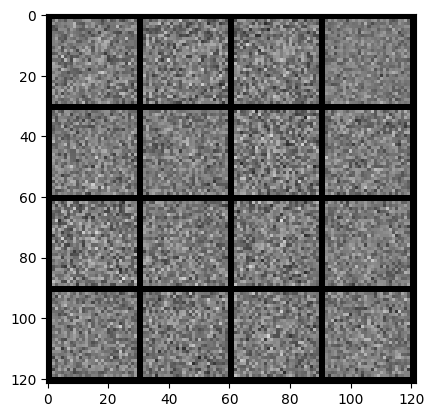

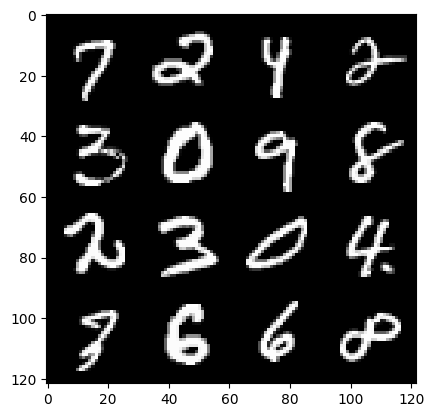

0: step 50 / Gen loss: 0.763509329557419 / disc_loss: 0.6736745142936706


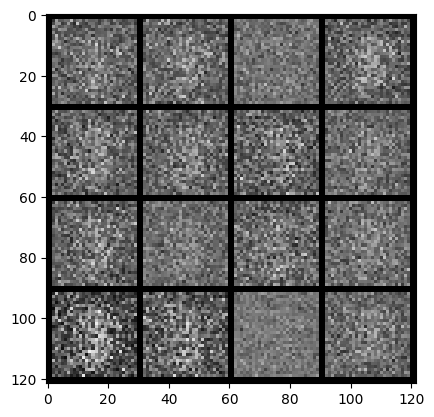

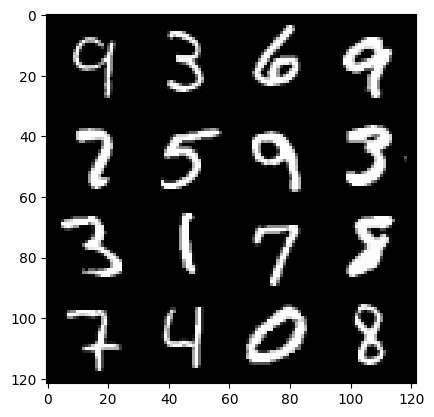

0: step 100 / Gen loss: 0.9453164851665495 / disc_loss: 0.5338384681940078


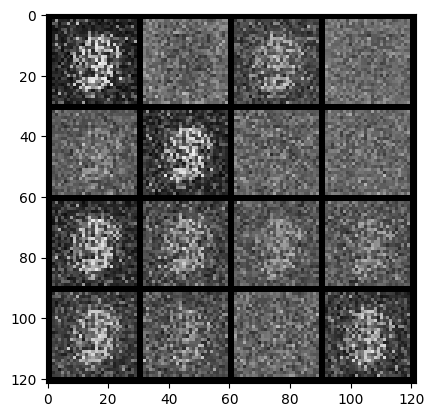

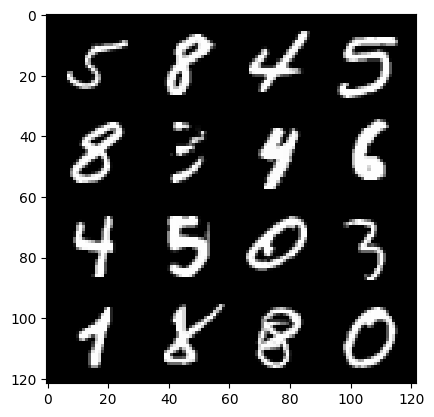

0: step 150 / Gen loss: 1.610684154033661 / disc_loss: 0.27384580761194227


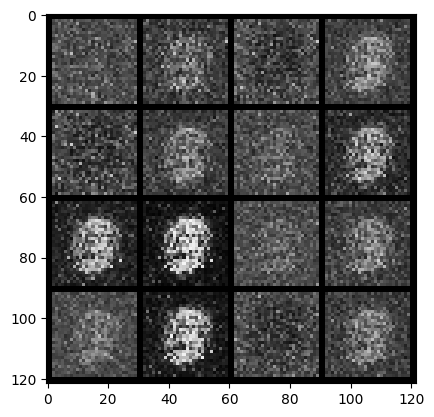

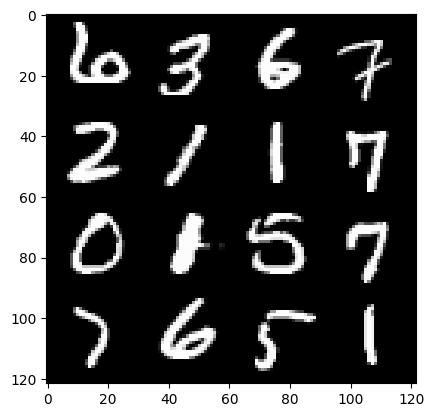

0: step 200 / Gen loss: 2.7184141492843628 / disc_loss: 0.12033222049474718


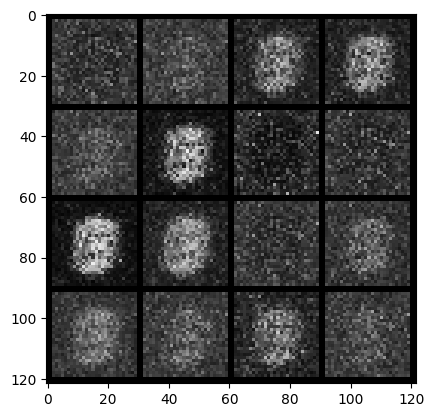

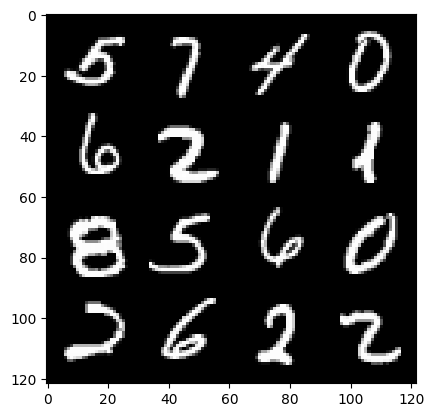

0: step 250 / Gen loss: 3.377077279090881 / disc_loss: 0.06698919102549551


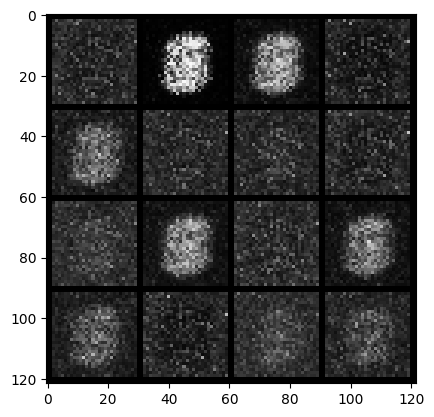

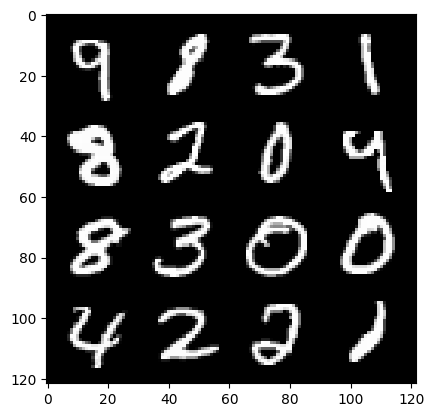

0: step 300 / Gen loss: 3.656785659790039 / disc_loss: 0.05514996938407421


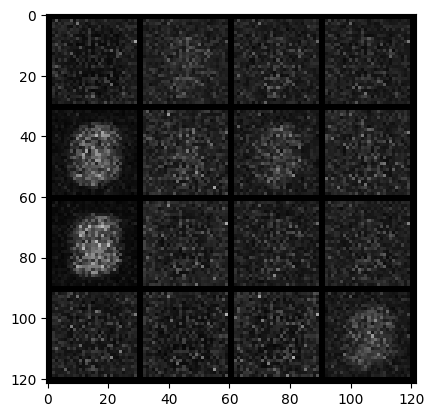

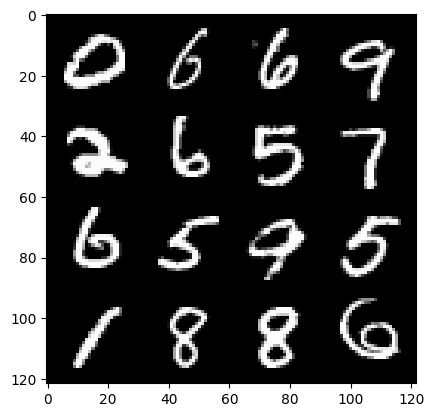

0: step 350 / Gen loss: 3.7344837331771843 / disc_loss: 0.05058598160743714


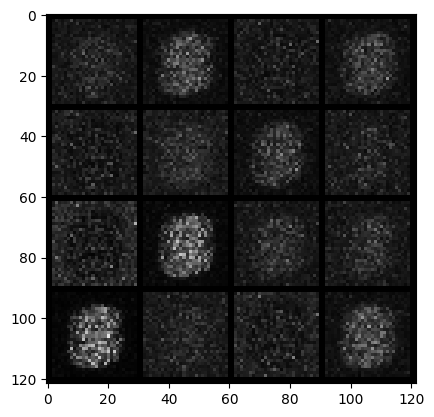

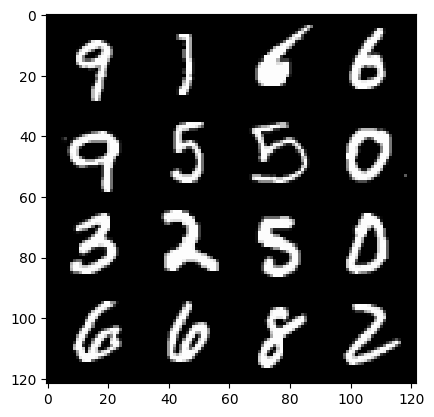

0: step 400 / Gen loss: 3.7222474288940433 / disc_loss: 0.04071680188179016


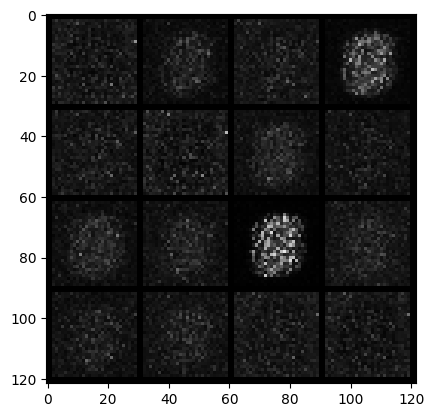

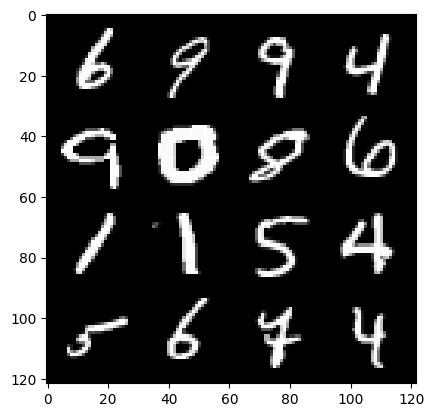

0: step 450 / Gen loss: 3.6765576171874987 / disc_loss: 0.03533049490302801


  0%|          | 0/469 [00:00<?, ?it/s]

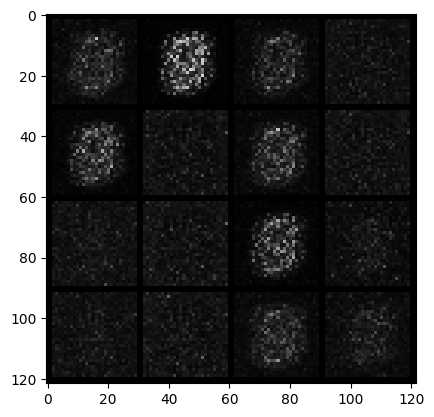

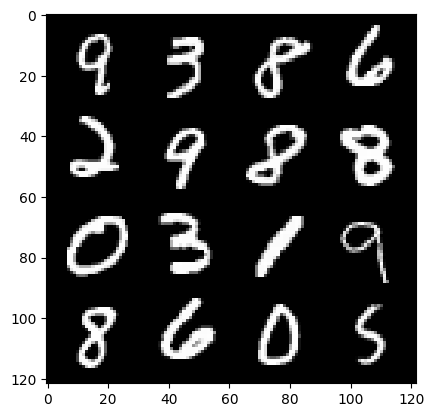

1: step 500 / Gen loss: 3.6535252523422237 / disc_loss: 0.029301458597183236


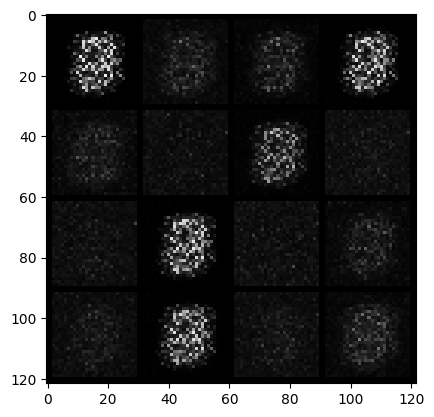

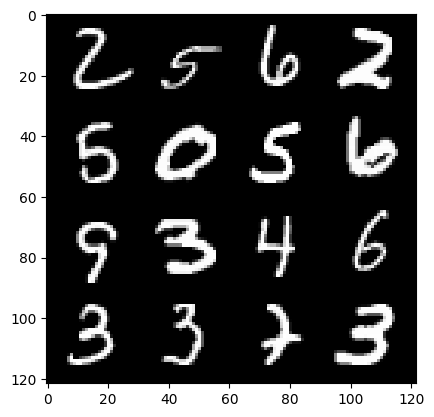

1: step 550 / Gen loss: 3.602726650238038 / disc_loss: 0.02875383421778679


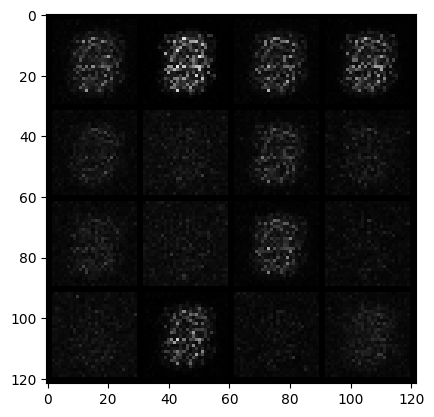

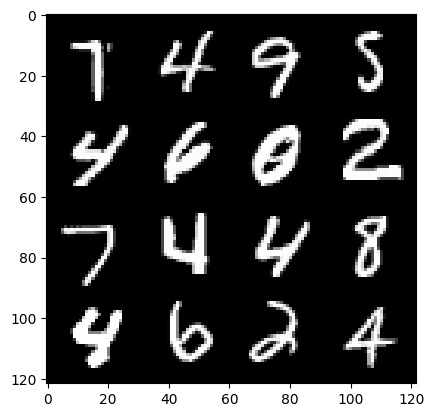

1: step 600 / Gen loss: 3.563424582481385 / disc_loss: 0.028359662108123296


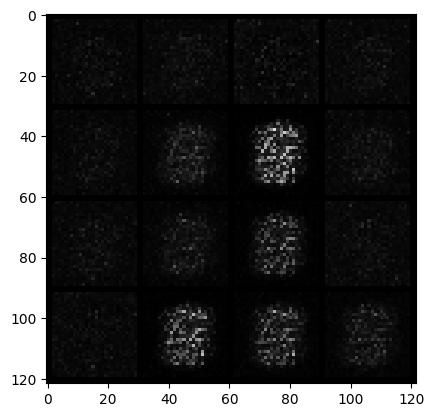

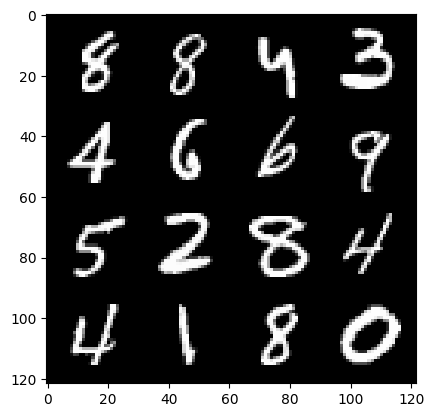

1: step 650 / Gen loss: 3.5510461711883554 / disc_loss: 0.029222832210361958


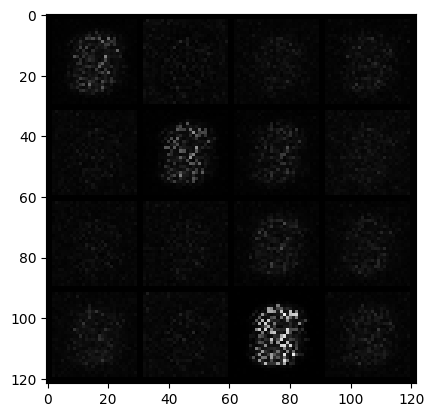

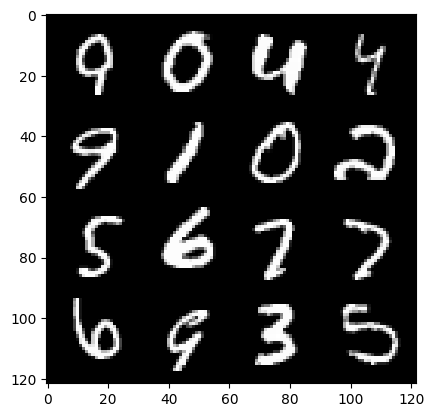

1: step 700 / Gen loss: 3.4857280492782596 / disc_loss: 0.03099164552986622


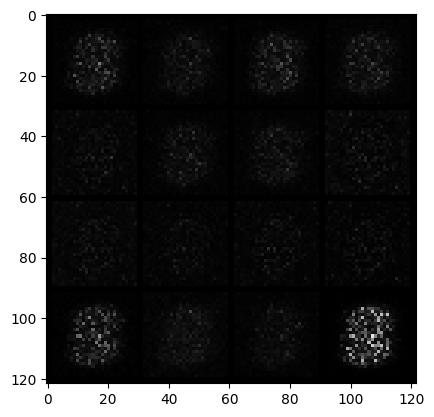

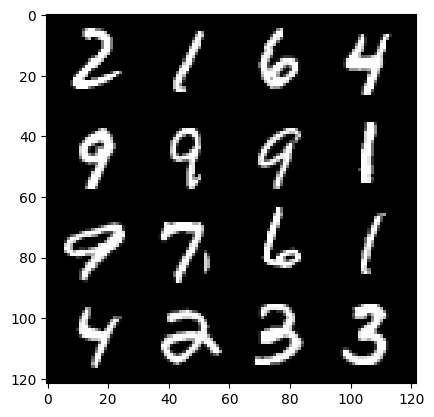

1: step 750 / Gen loss: 3.499826536178589 / disc_loss: 0.029971481375396253


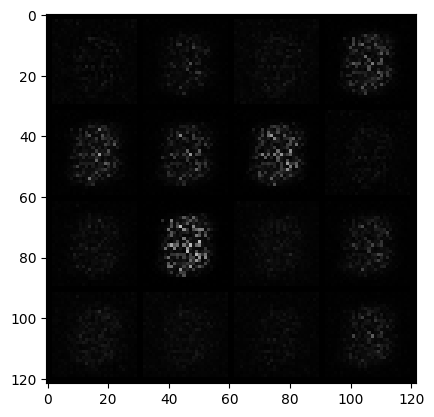

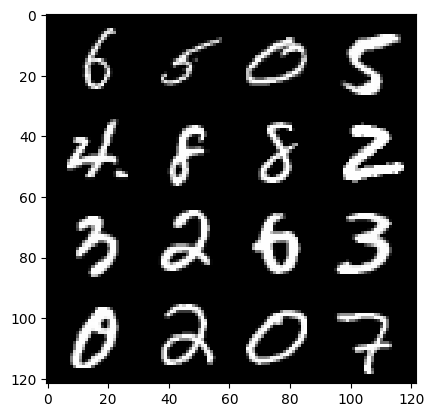

1: step 800 / Gen loss: 3.425466213226318 / disc_loss: 0.03561520539224148


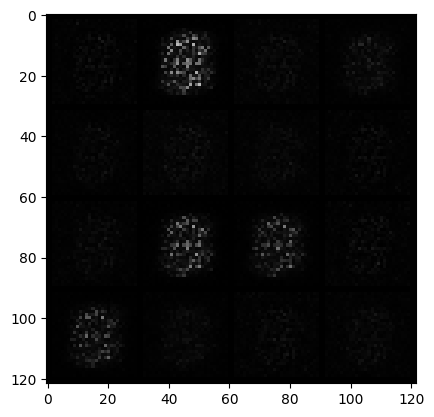

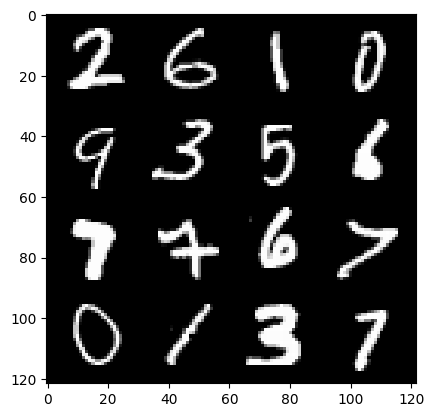

1: step 850 / Gen loss: 3.5190943908691397 / disc_loss: 0.028885488845407967


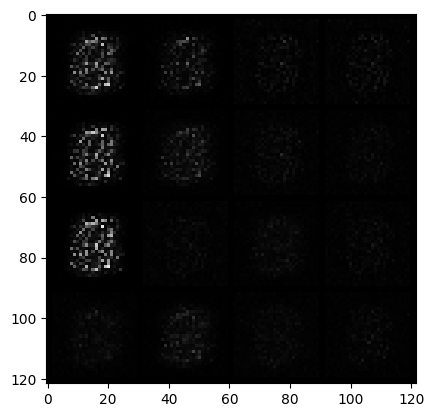

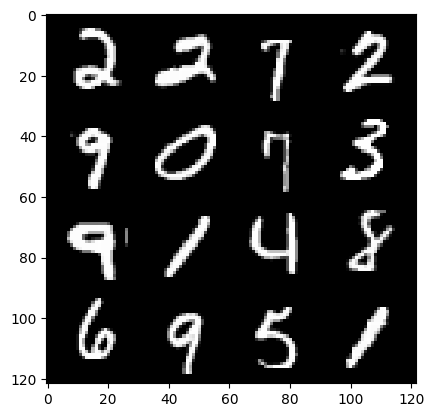

1: step 900 / Gen loss: 3.577699069976807 / disc_loss: 0.03023376941680908


  0%|          | 0/469 [00:00<?, ?it/s]

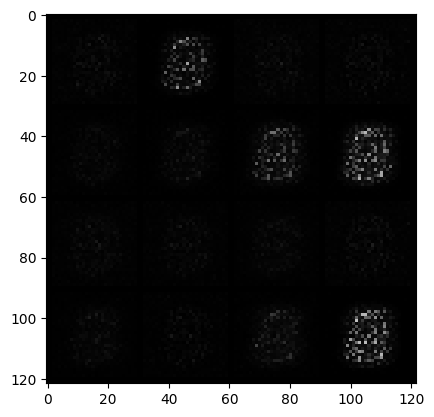

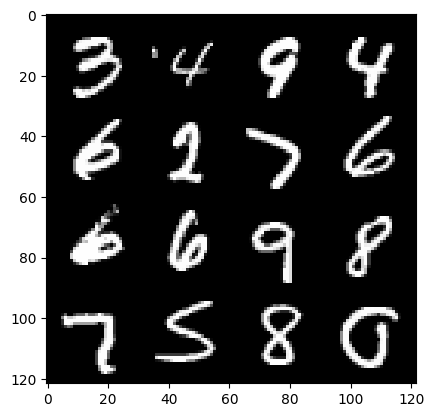

2: step 950 / Gen loss: 3.5415297174453726 / disc_loss: 0.03415788173675537


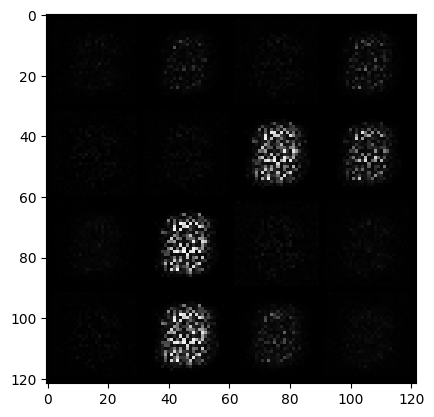

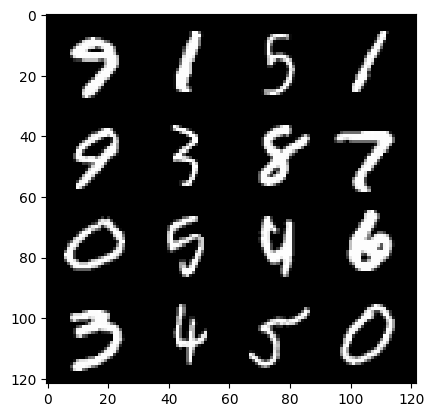

2: step 1000 / Gen loss: 3.6168410778045654 / disc_loss: 0.0330916852131486


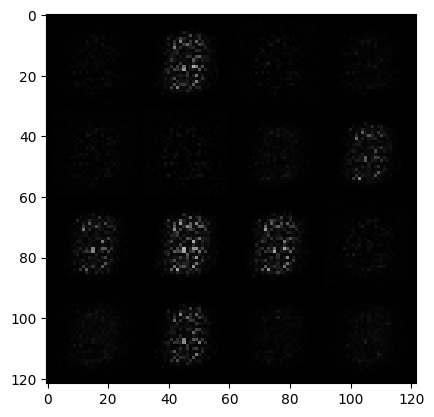

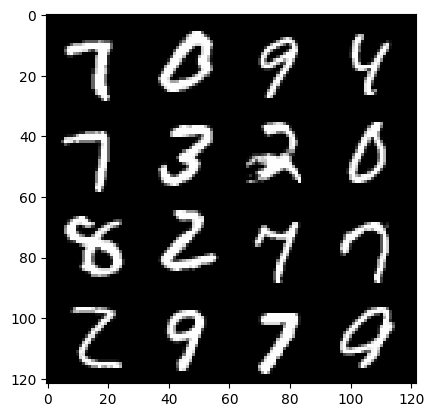

2: step 1050 / Gen loss: 3.716128907203673 / disc_loss: 0.036355112306773664


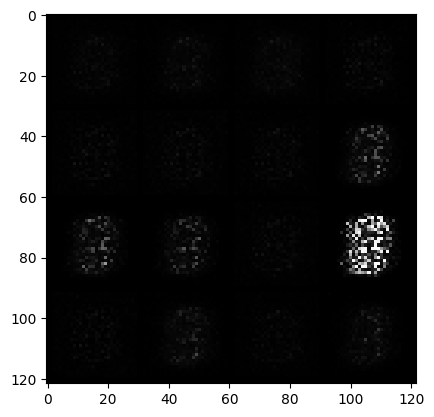

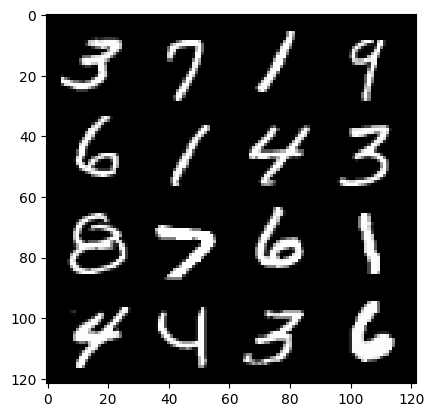

2: step 1100 / Gen loss: 3.6833151721954347 / disc_loss: 0.028731408379971984


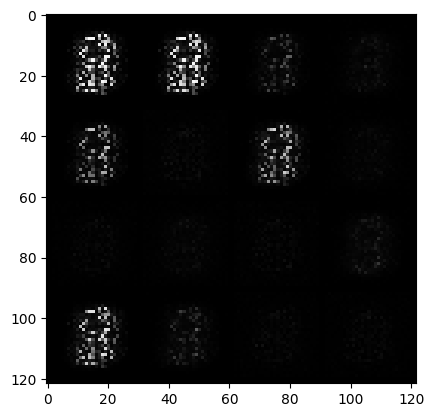

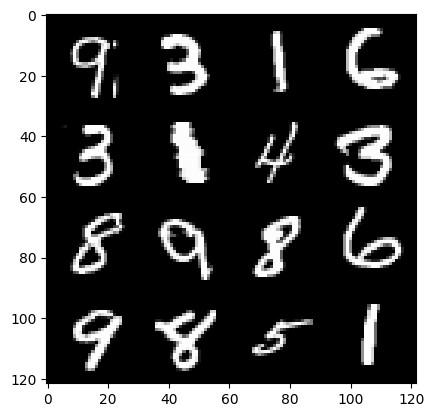

2: step 1150 / Gen loss: 3.8513052368164056 / disc_loss: 0.024375735782086846


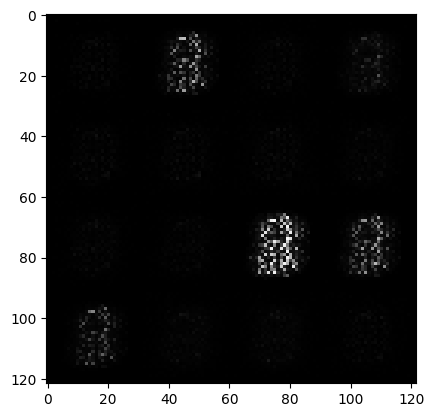

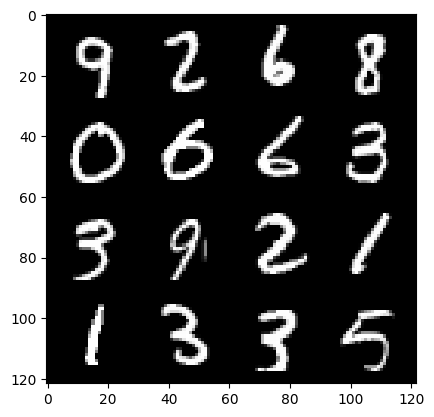

2: step 1200 / Gen loss: 3.912990431785584 / disc_loss: 0.026704222448170174


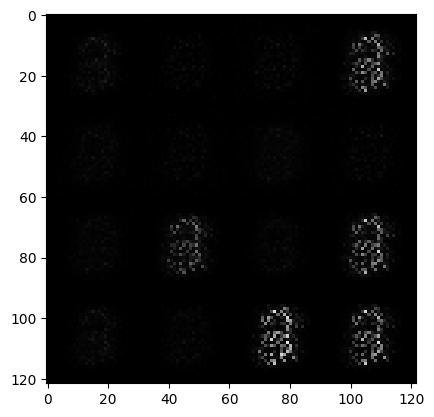

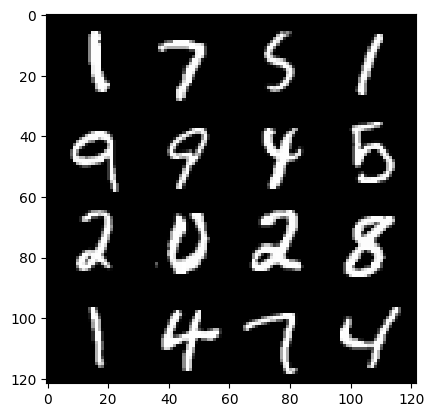

2: step 1250 / Gen loss: 3.9662540817260736 / disc_loss: 0.0253836850821972


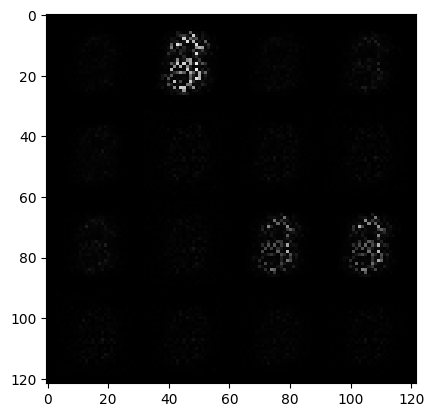

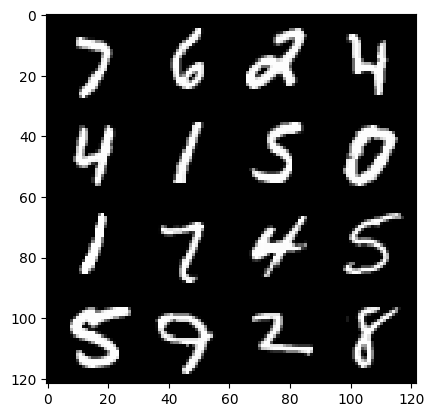

2: step 1300 / Gen loss: 3.997802133560179 / disc_loss: 0.022607681993395096


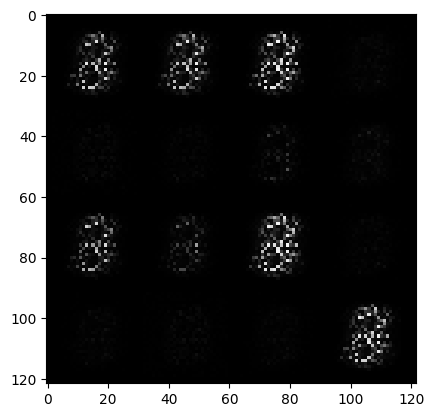

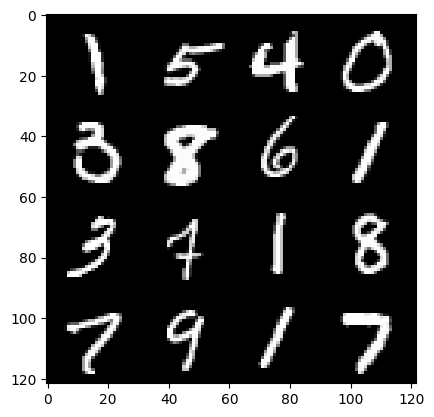

2: step 1350 / Gen loss: 4.088569898605348 / disc_loss: 0.022307718489319086


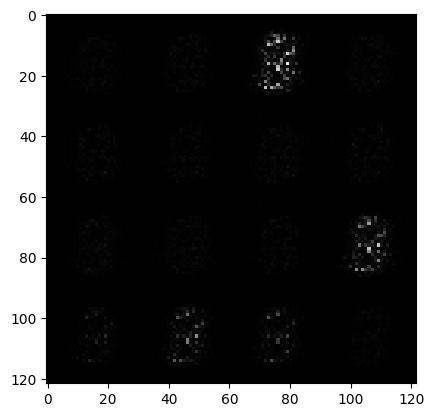

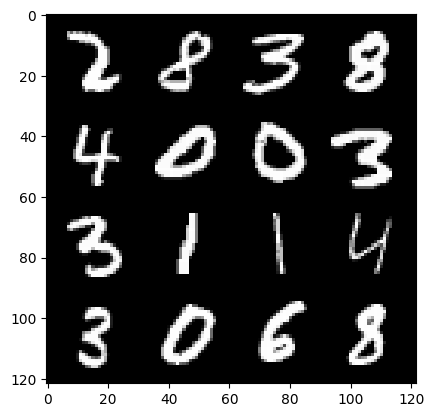

2: step 1400 / Gen loss: 4.281189622879028 / disc_loss: 0.021386429872363808


  0%|          | 0/469 [00:00<?, ?it/s]

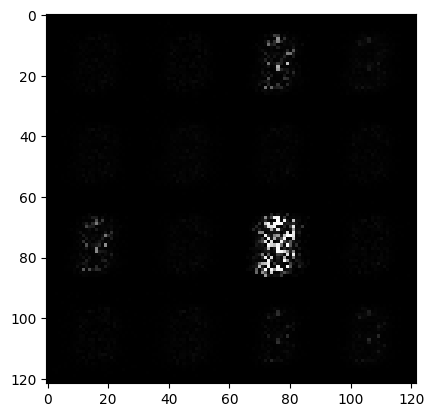

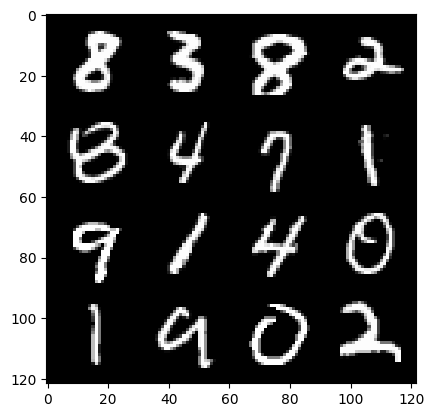

3: step 1450 / Gen loss: 4.341524438858032 / disc_loss: 0.017849425915628665


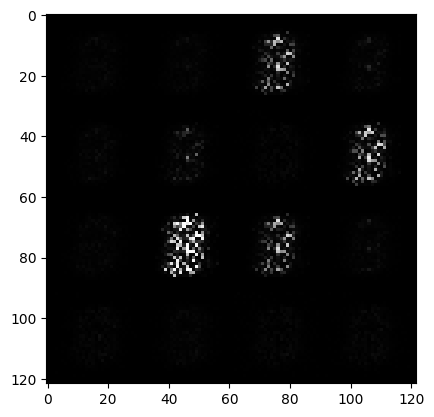

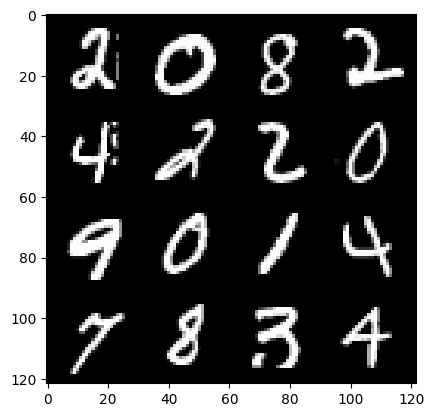

3: step 1500 / Gen loss: 4.389644756317138 / disc_loss: 0.01514708297327161


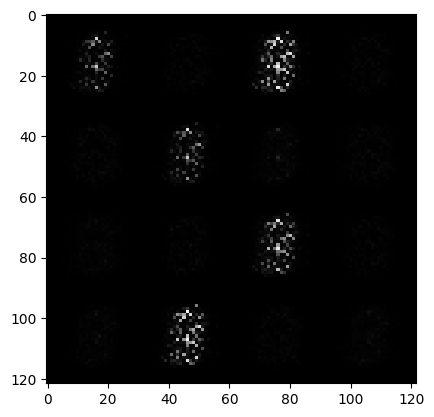

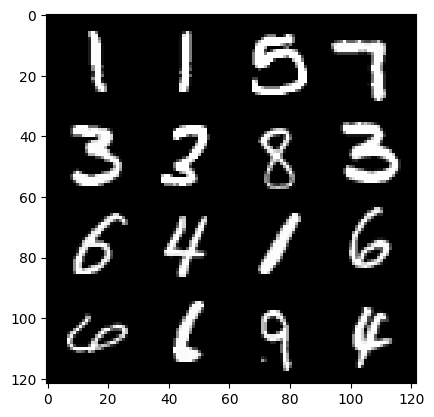

3: step 1550 / Gen loss: 4.326411671638489 / disc_loss: 0.014646781217306854


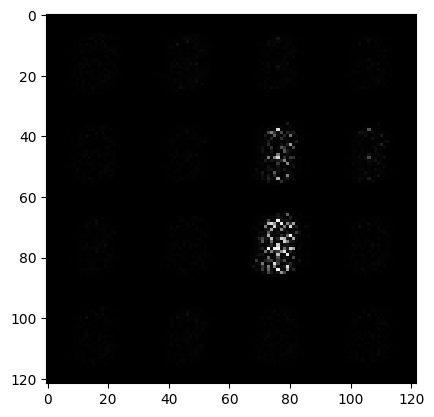

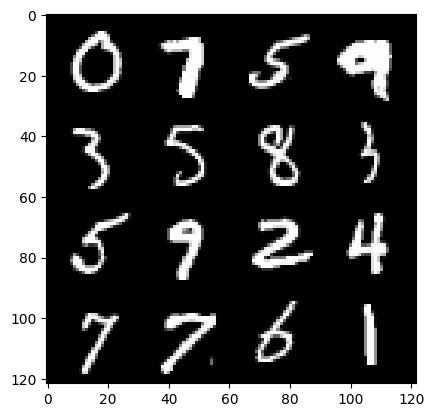

3: step 1600 / Gen loss: 4.518425874710083 / disc_loss: 0.014324599765241149


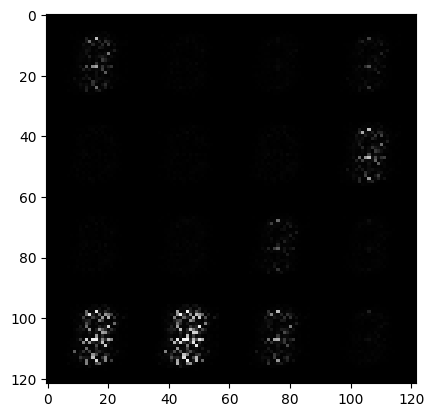

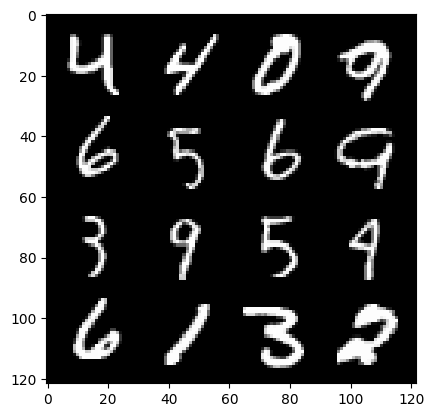

3: step 1650 / Gen loss: 4.610683126449585 / disc_loss: 0.012827462721616032


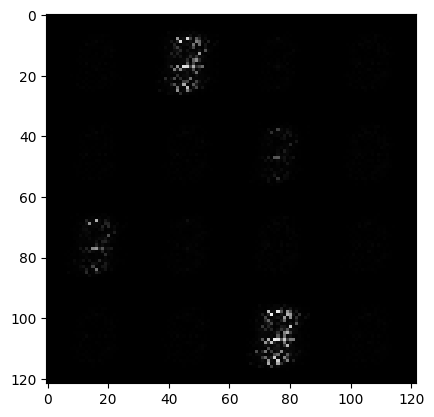

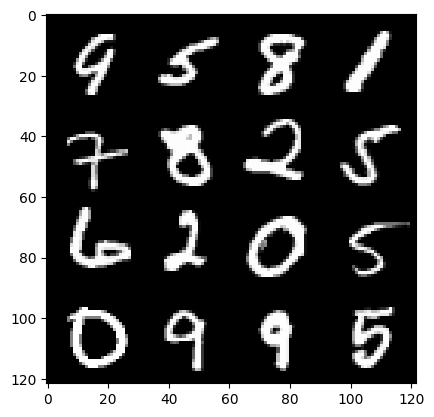

3: step 1700 / Gen loss: 4.717819185256958 / disc_loss: 0.012496300879865887


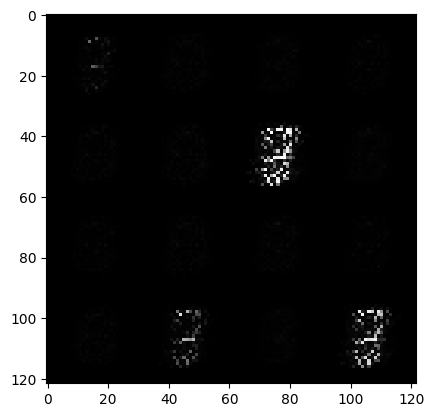

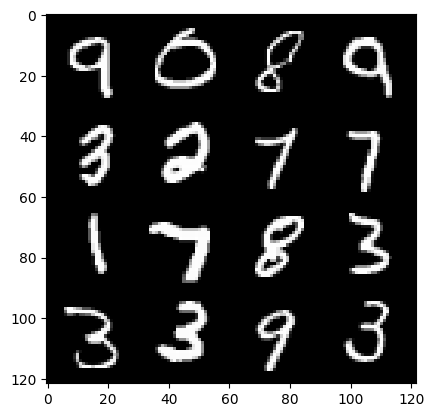

3: step 1750 / Gen loss: 4.771306648254394 / disc_loss: 0.010830079885199663


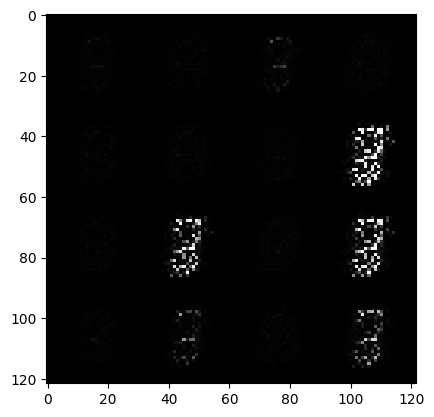

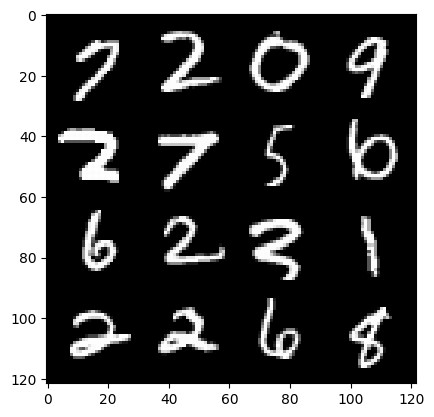

3: step 1800 / Gen loss: 4.804765024185181 / disc_loss: 0.009655847046524288


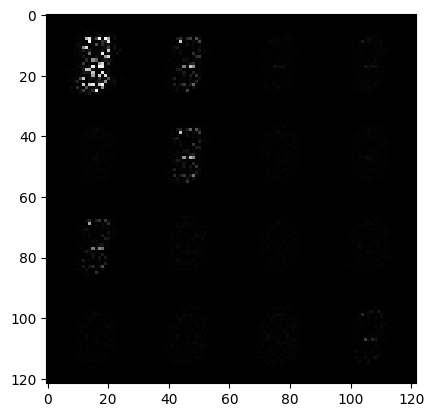

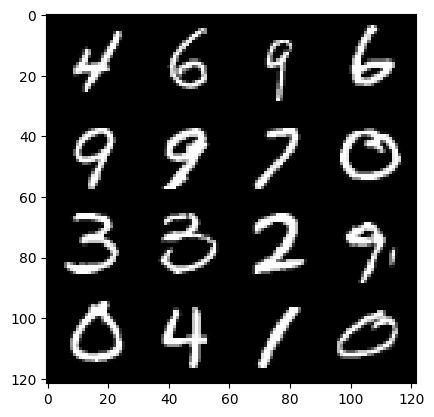

3: step 1850 / Gen loss: 4.955926837921143 / disc_loss: 0.008859050003811715


  0%|          | 0/469 [00:00<?, ?it/s]

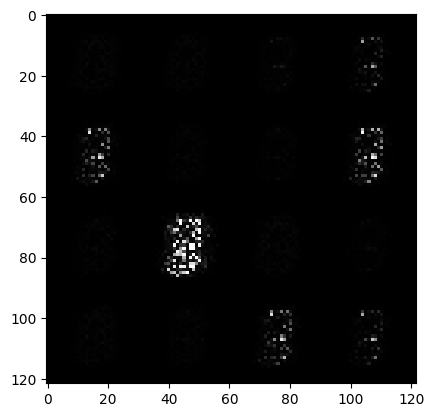

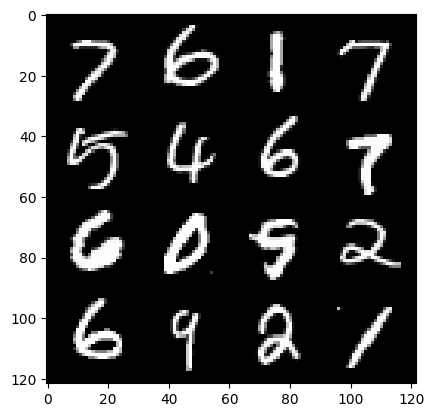

4: step 1900 / Gen loss: 5.163432226181031 / disc_loss: 0.009922153139486908


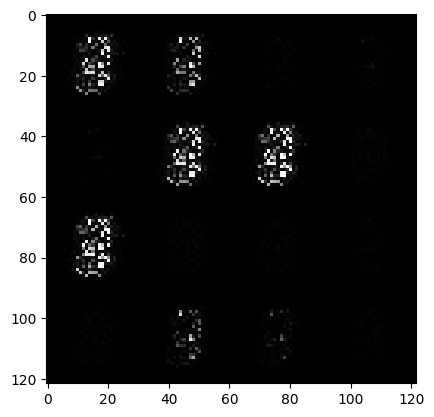

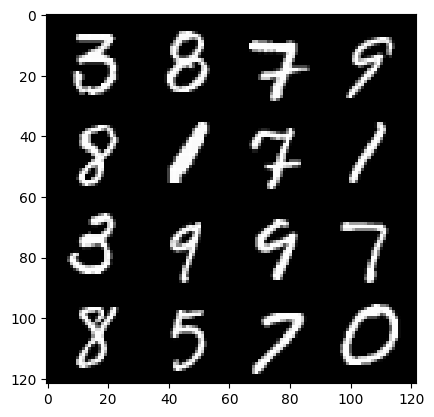

4: step 1950 / Gen loss: 5.20215955734253 / disc_loss: 0.008931616367772222


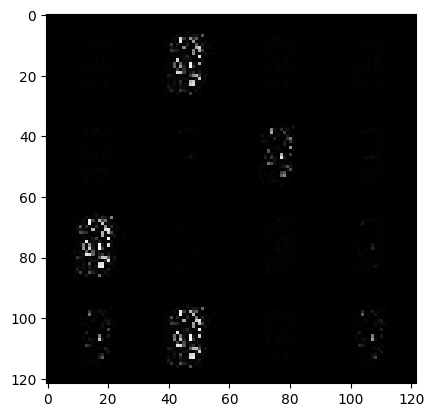

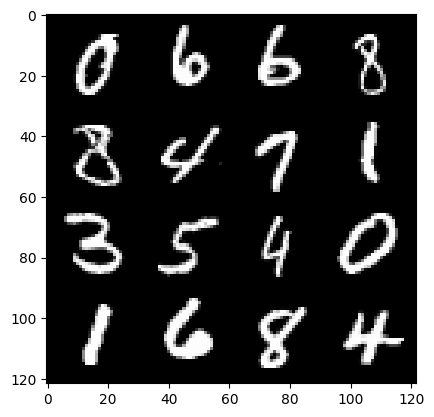

4: step 2000 / Gen loss: 5.2466711616516095 / disc_loss: 0.008839103248901662


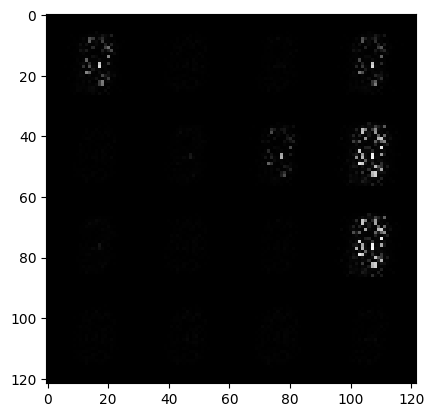

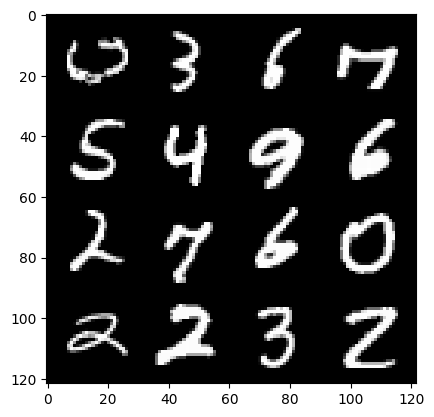

4: step 2050 / Gen loss: 5.332222537994386 / disc_loss: 0.00828144414816052


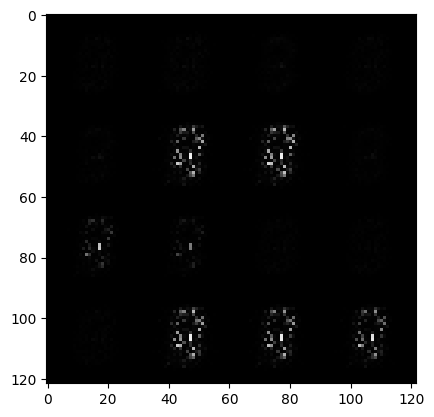

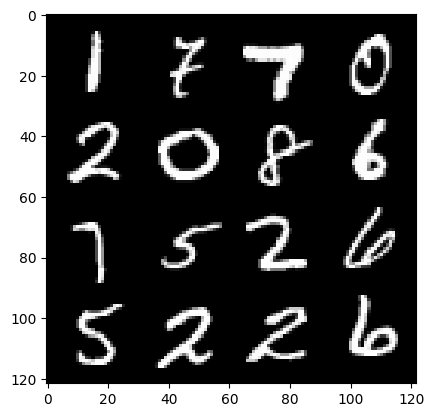

4: step 2100 / Gen loss: 5.47398648262024 / disc_loss: 0.008159796497784555


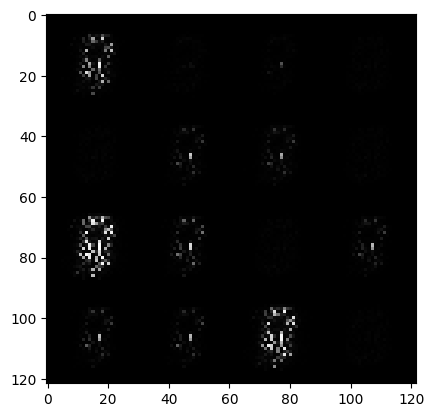

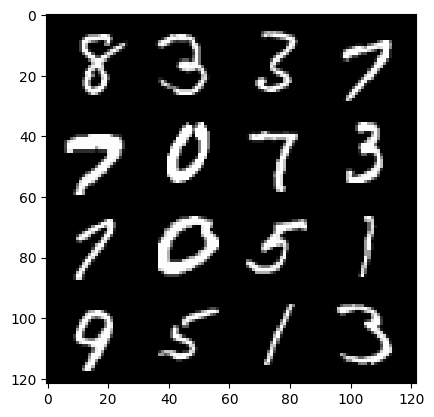

4: step 2150 / Gen loss: 5.399538259506226 / disc_loss: 0.009334112368524073


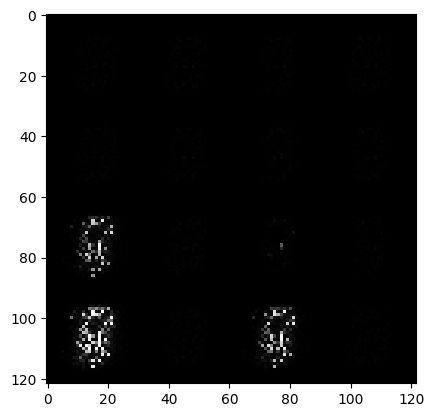

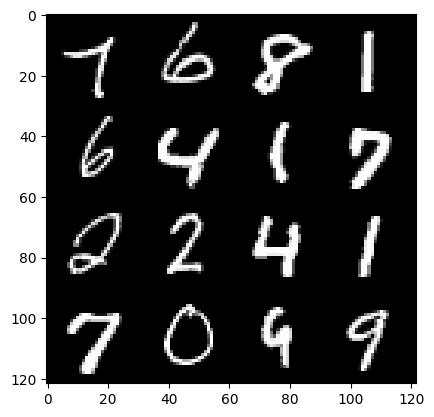

4: step 2200 / Gen loss: 5.581633644104004 / disc_loss: 0.0074863815587013945


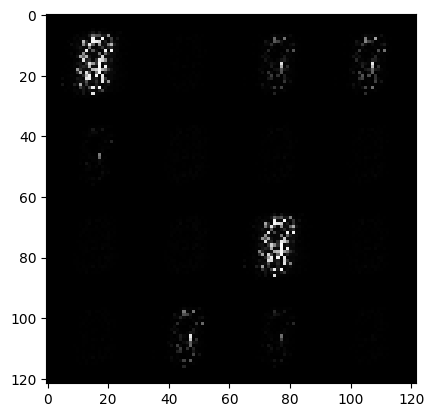

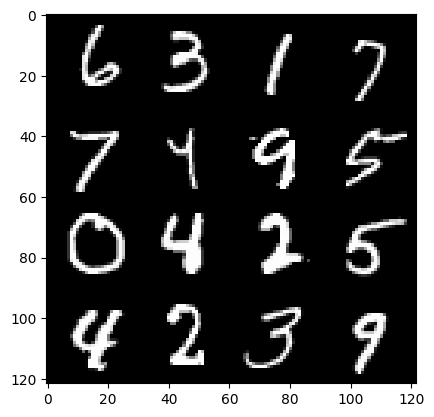

4: step 2250 / Gen loss: 5.781193332672122 / disc_loss: 0.00844364826567471


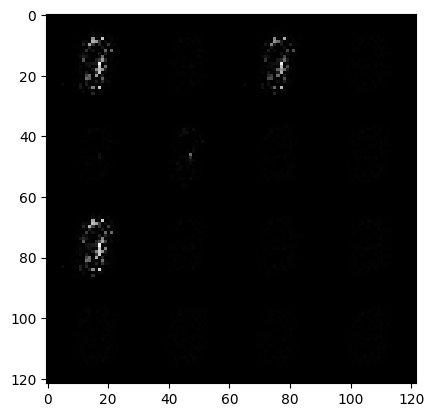

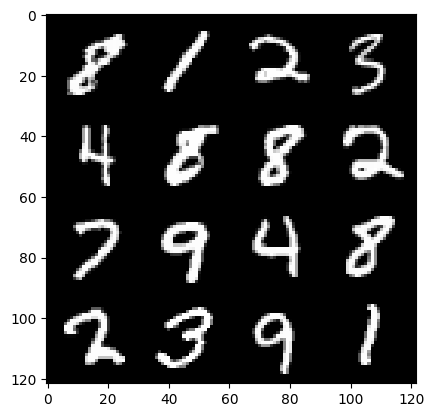

4: step 2300 / Gen loss: 5.668837385177612 / disc_loss: 0.006024084058590233


  0%|          | 0/469 [00:00<?, ?it/s]

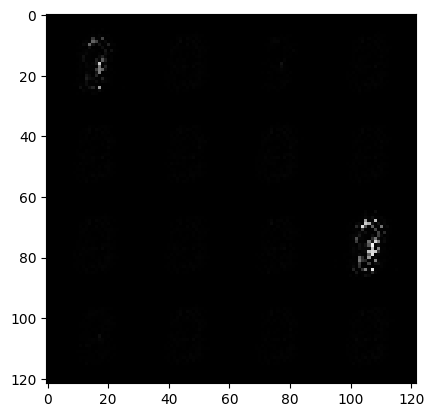

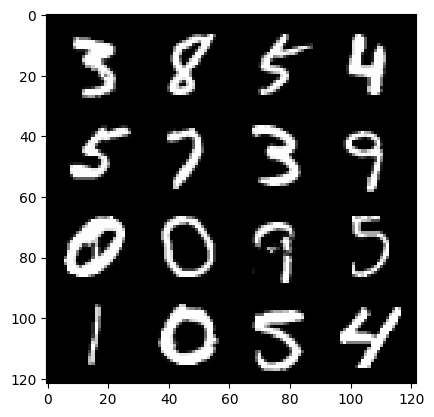

5: step 2350 / Gen loss: 5.6447646236419695 / disc_loss: 0.005701088812202216


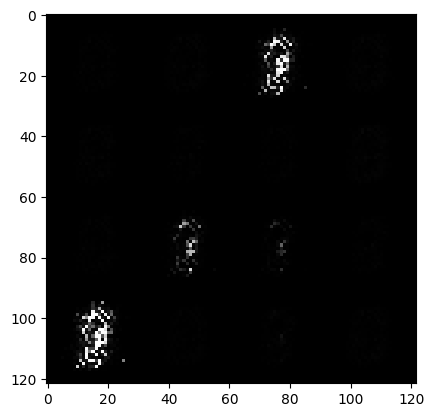

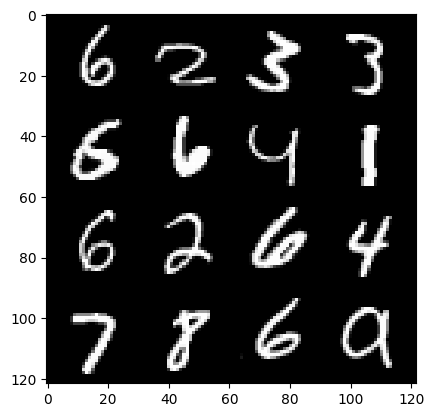

5: step 2400 / Gen loss: 5.738951635360718 / disc_loss: 0.004911357746459545


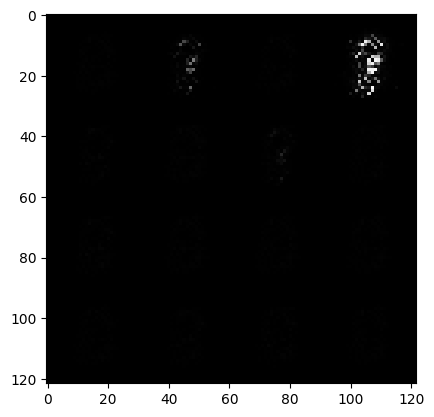

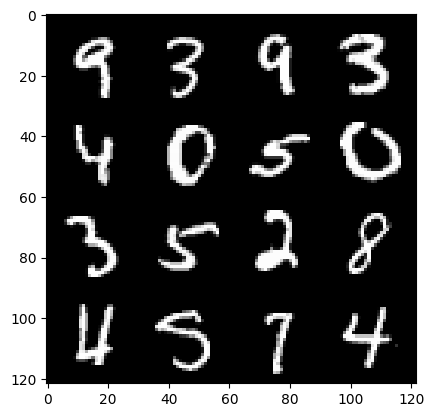

5: step 2450 / Gen loss: 5.796004161834717 / disc_loss: 0.006100058290176091


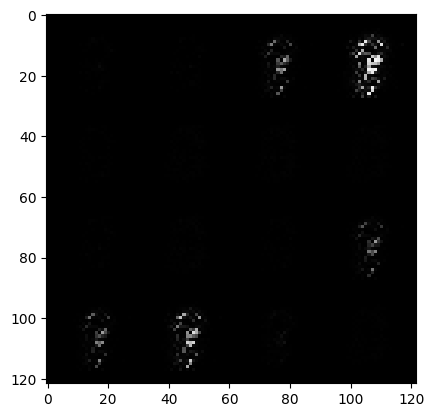

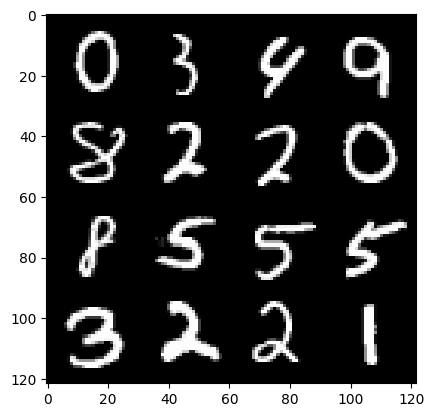

5: step 2500 / Gen loss: 5.9351027679443344 / disc_loss: 0.00765809688717127


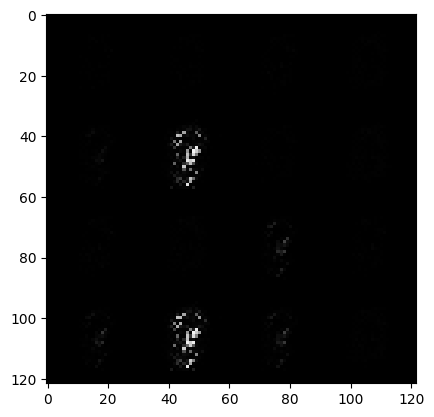

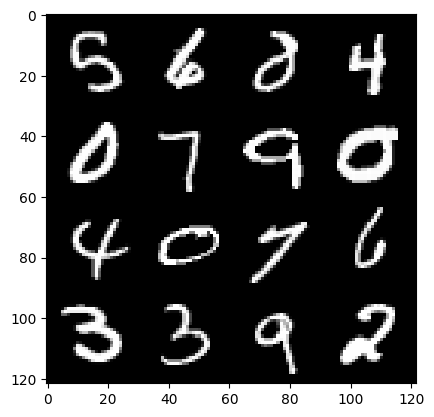

5: step 2550 / Gen loss: 5.830467796325685 / disc_loss: 0.0055359883187338695


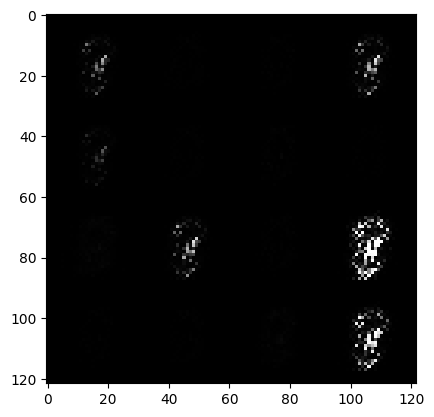

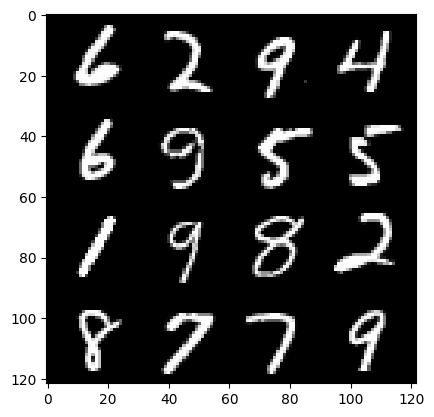

5: step 2600 / Gen loss: 5.725808563232423 / disc_loss: 0.005260435151867566


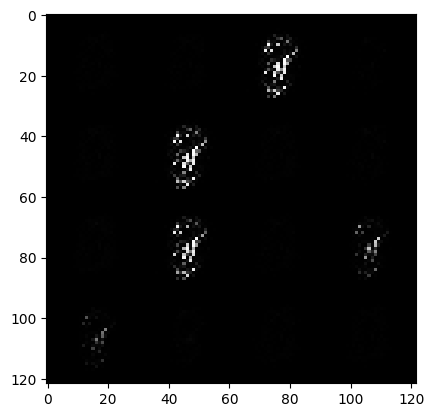

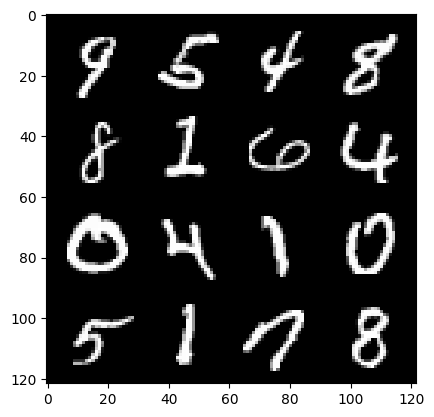

5: step 2650 / Gen loss: 5.787096319198607 / disc_loss: 0.006015447364188731


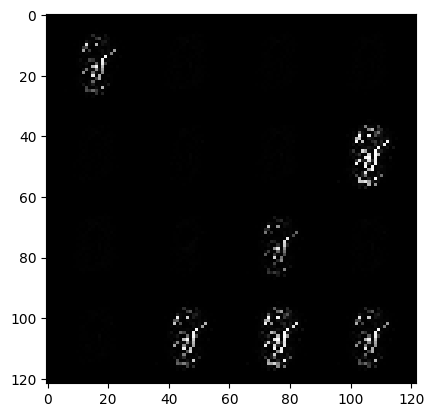

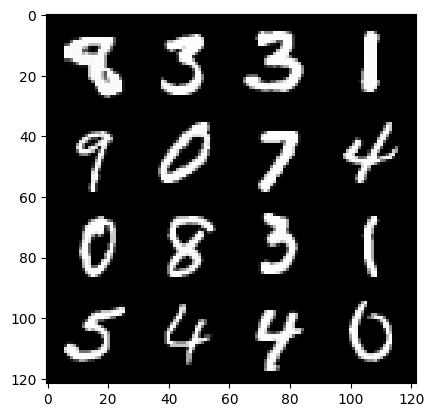

5: step 2700 / Gen loss: 6.089730930328369 / disc_loss: 0.005473386608064176


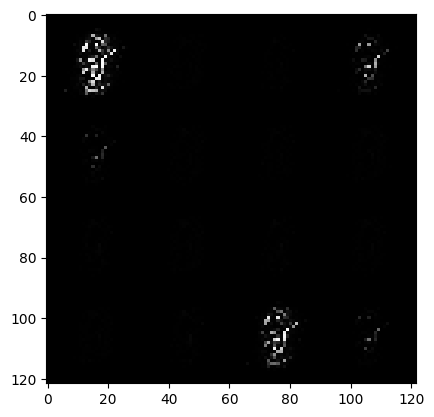

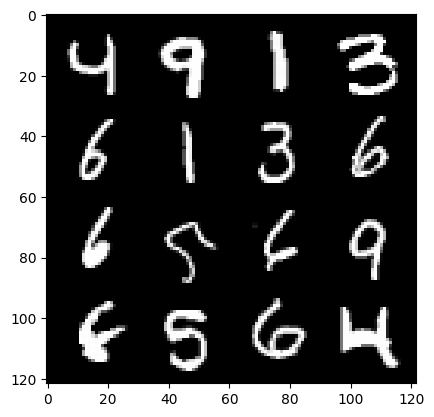

5: step 2750 / Gen loss: 6.231769094467163 / disc_loss: 0.005984229587484152


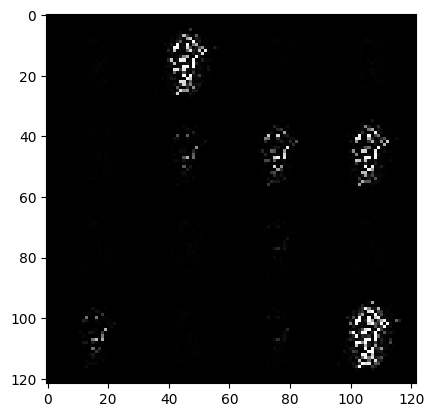

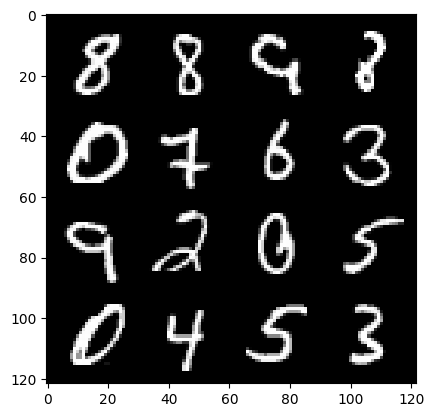

5: step 2800 / Gen loss: 6.237765293121336 / disc_loss: 0.005386594745796175


  0%|          | 0/469 [00:00<?, ?it/s]

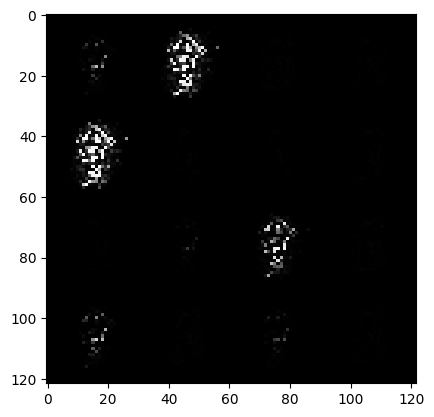

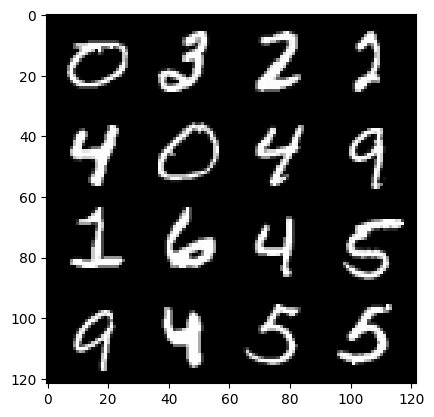

6: step 2850 / Gen loss: 6.269965915679931 / disc_loss: 0.004684334874618798


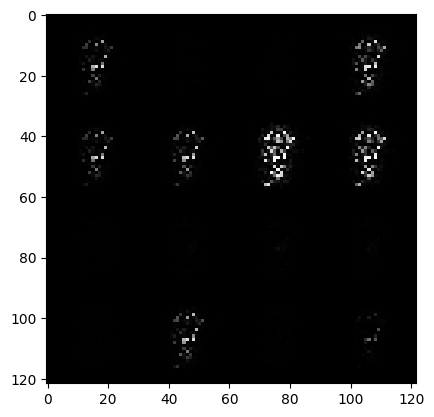

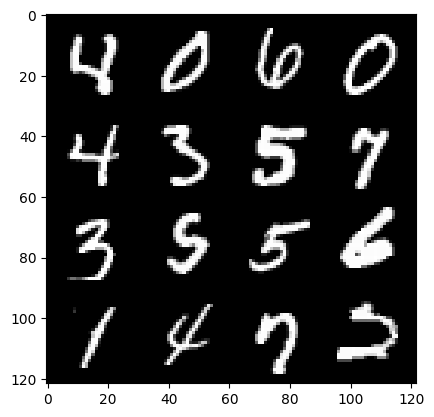

6: step 2900 / Gen loss: 6.265149583816529 / disc_loss: 0.004041224247775972


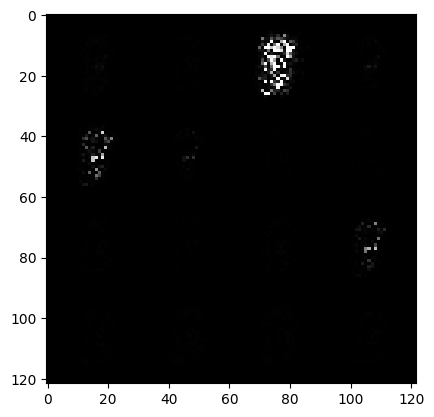

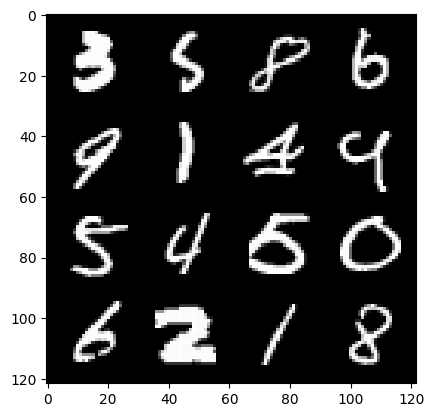

6: step 2950 / Gen loss: 6.275581884384155 / disc_loss: 0.003981829455588013


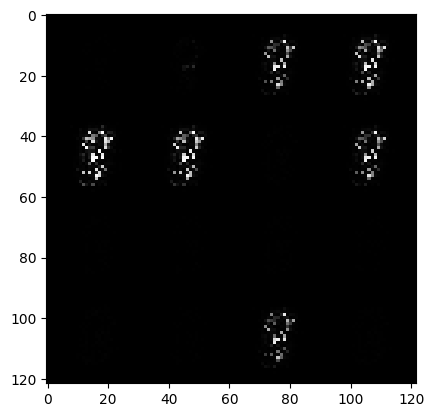

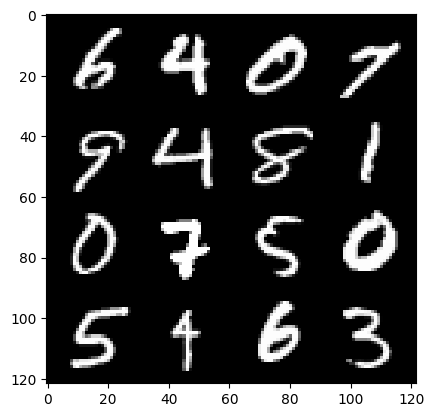

6: step 3000 / Gen loss: 6.317633819580078 / disc_loss: 0.004485331419855357


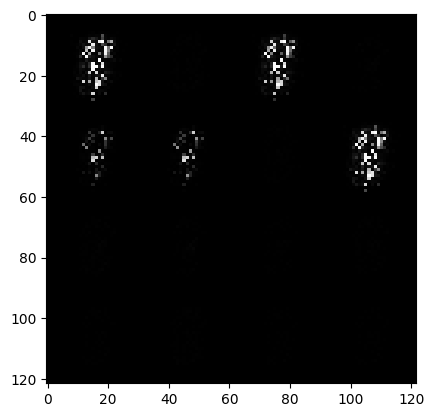

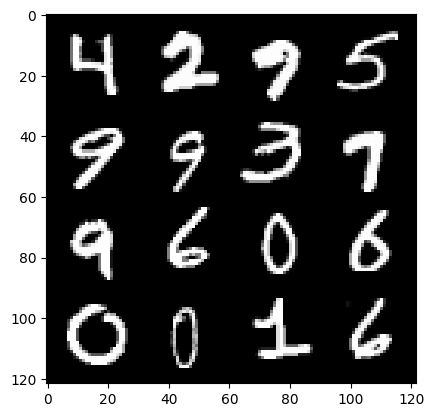

6: step 3050 / Gen loss: 6.531530895233155 / disc_loss: 0.004319119825959206


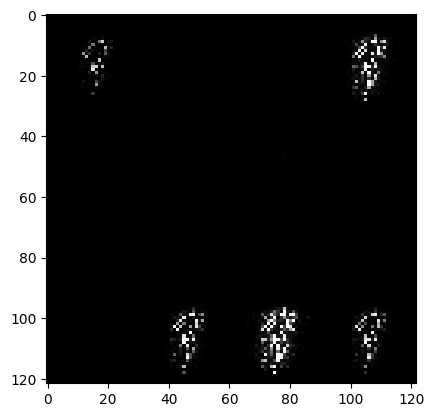

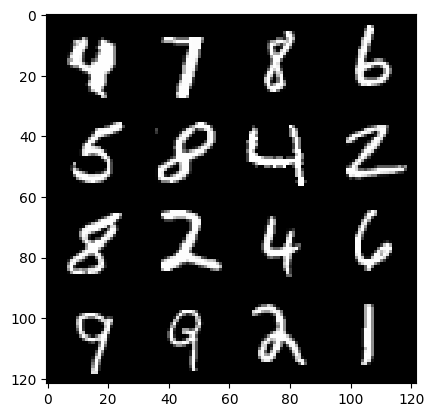

6: step 3100 / Gen loss: 6.532423782348633 / disc_loss: 0.004889970405492931


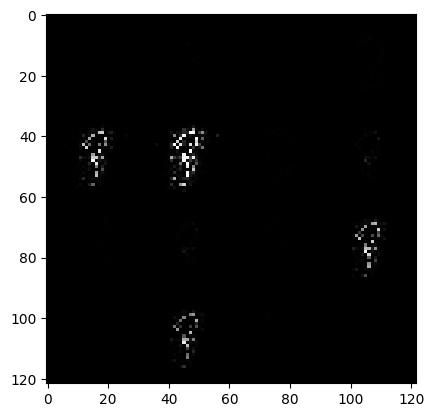

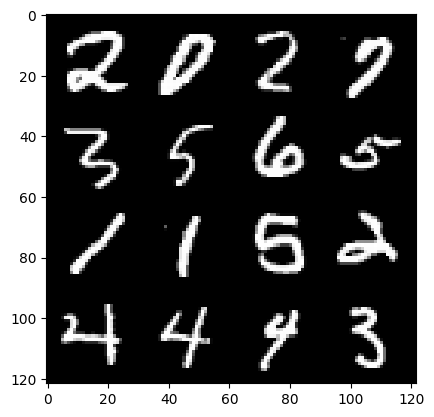

6: step 3150 / Gen loss: 6.650959072113037 / disc_loss: 0.004467115786392242


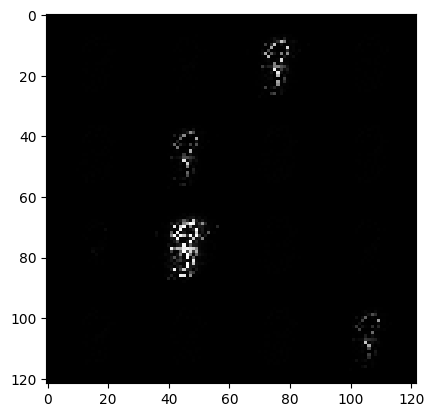

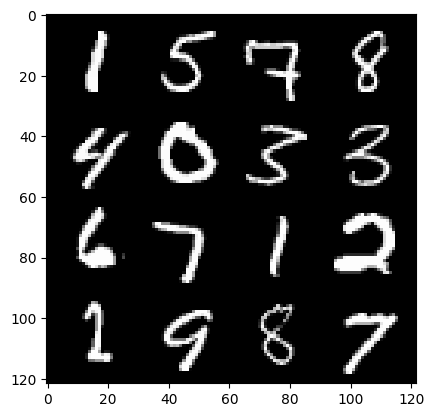

6: step 3200 / Gen loss: 6.684968996047974 / disc_loss: 0.0036327904008794576


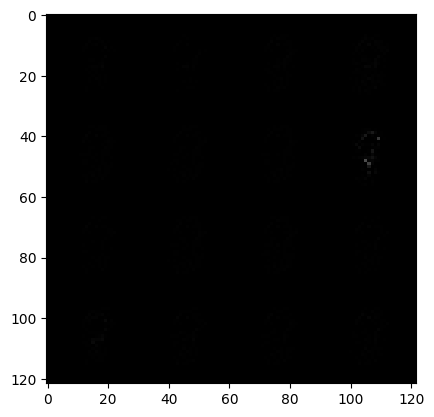

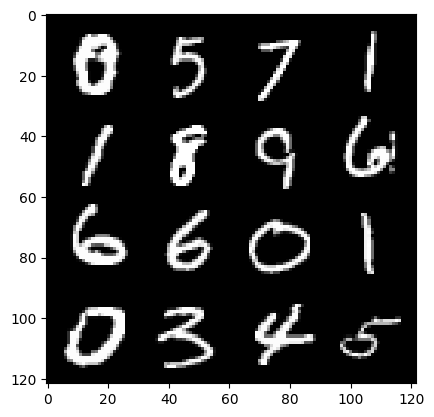

6: step 3250 / Gen loss: 6.613504371643066 / disc_loss: 0.0041029839194379756


  0%|          | 0/469 [00:00<?, ?it/s]

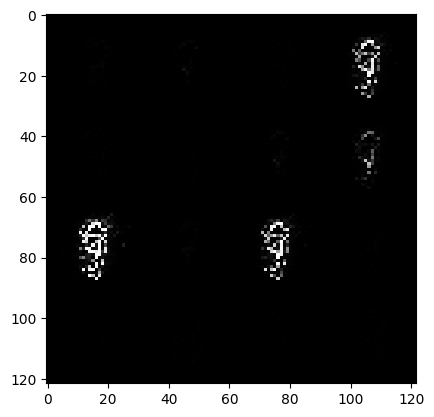

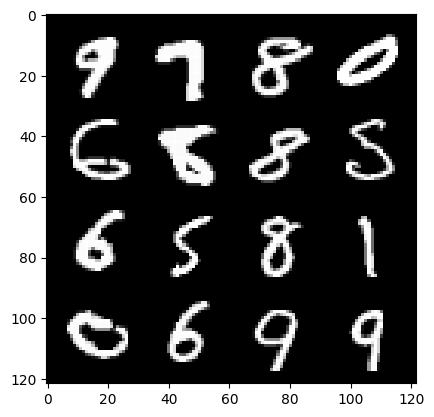

7: step 3300 / Gen loss: 6.692257442474364 / disc_loss: 0.003447442555334419


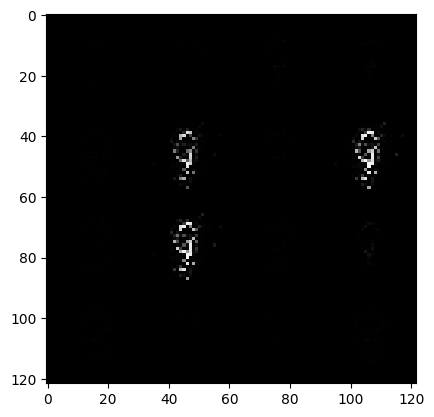

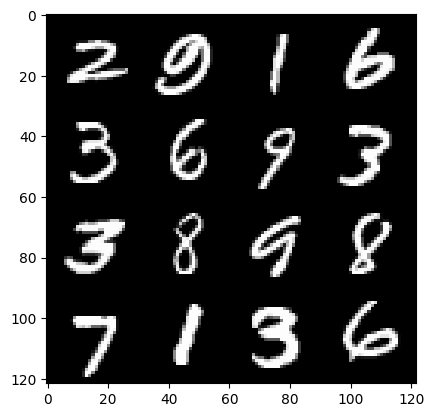

7: step 3350 / Gen loss: 6.592162342071532 / disc_loss: 0.0030772511451505127


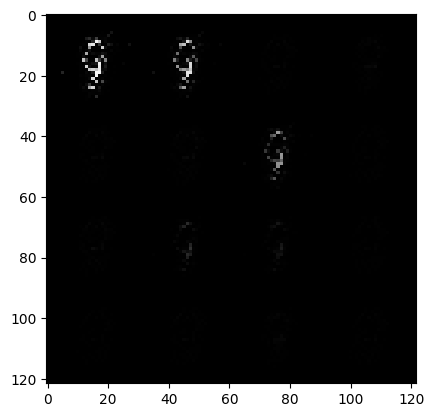

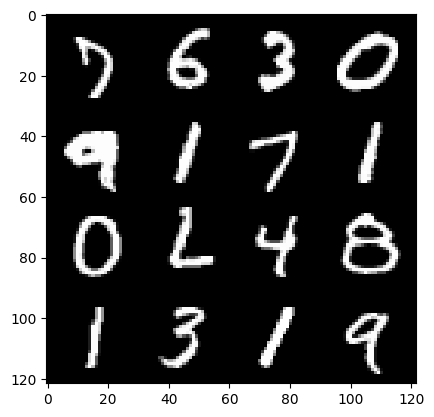

7: step 3400 / Gen loss: 6.65098030090332 / disc_loss: 0.00306841384852305


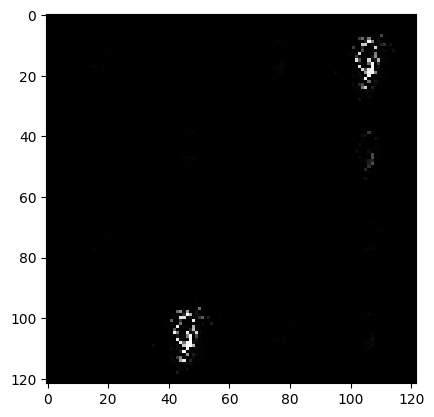

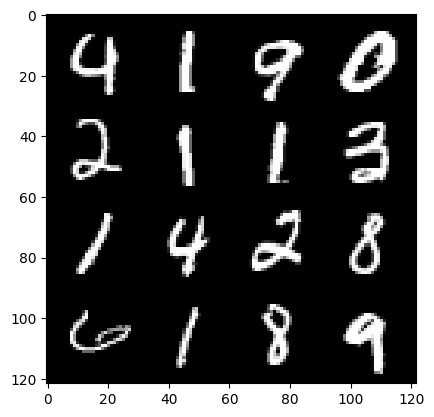

7: step 3450 / Gen loss: 6.729367084503173 / disc_loss: 0.003673704674001782


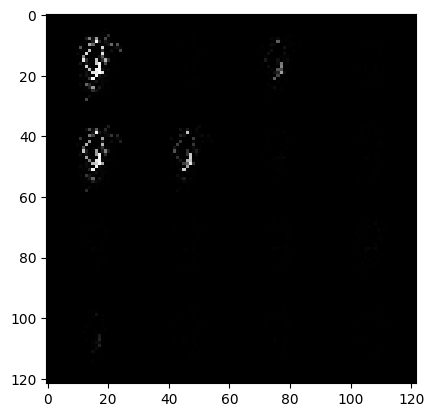

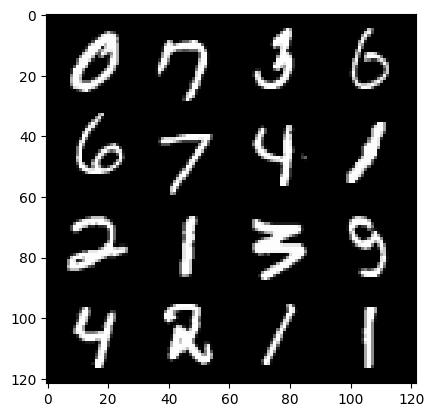

7: step 3500 / Gen loss: 6.816430749893189 / disc_loss: 0.003490056716836989


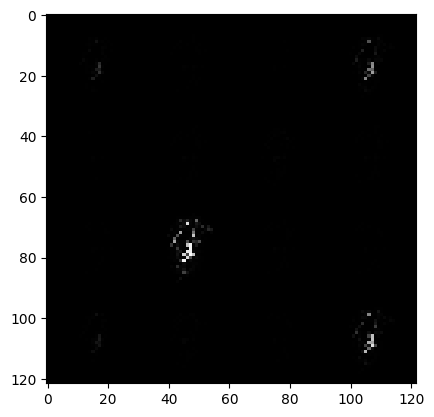

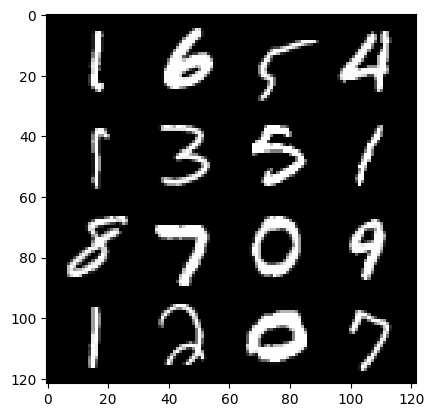

7: step 3550 / Gen loss: 6.707524194717407 / disc_loss: 0.004503064285963774


KeyboardInterrupt: ignored

In [14]:
### Each step is going to process 128 images = size of the batch (except the last step)

for epoch in range(num_epochs):
  for real, _ in tqdm(dataloader):
    ### discriminator
    disc_opt.zero_grad()

    cur_bs=len(real) # real: 128 x 1 x 28 x 28
    real = real.view(cur_bs, -1) # 128 x 784
    real = real.to(device)

    disc_loss = calc_disc_loss(loss_fncn,gen,disc,cur_bs,real,nois_dim)
    disc_loss.backward(retain_graph=True)
    disc_opt.step()

    ### generator
    gen_opt.zero_grad()
    gen_loss = calc_gen_loss(loss_fncn,gen,disc,cur_bs,nois_dim)
    gen_loss.backward(retain_graph=True)
    gen_opt.step()

    ### visualization & stats
    mean_disc_loss+=disc_loss.item()/info_epoch
    mean_gen_loss+=gen_loss.item()/info_epoch

    if curr % info_epoch == 0 and curr>0:
      fake_noise = create_noise(cur_bs, nois_dim)
      fake = gen(fake_noise)
      show(fake)
      show(real)
      print(f"{epoch}: step {curr} / Gen loss: {mean_gen_loss} / disc_loss: {mean_disc_loss}")
      mean_gen_loss, mean_disc_loss=0,0
    curr+=1
